## Temperature time series & Temperature masked for a selected area of interest


This notebook explores temperature data for Portugal using an Object-Oriented Programming (OOP) approach and geospatial analysis techniques. The temperature data is sourced from the CDS datastore and is specifically downloaded for parts of the Iberian Peninsula. However, for this use case, we focus on extracting temperature data for Portugal for a single year. This notebook showcases how to read and visualize NetCDF (nc) files, as well as work with administrative boundaries of Portugal using GeoDataFrames.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask
import matplotlib.patheffects as pe

In [2]:
# Set plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

In [4]:
# Define a class for data handling
class Temp:
    def __init__(self, nc_path, shape_path):
        """
        Initialize the Temp class.

        Parameters:
        - nc_path (str): Path to the NetCDF file.
        - shape_path (str): Path to the shapefile.
        """
        self.nc_path = nc_path
        self.shape_path = shape_path
        self.t2m = None
        self.gdf = None
        self.porto_aoi = None
    
    def read_netCDF(self):
        """Read the NetCDF file and store it in self.t2m."""
        with xr.open_dataset(self.nc_path) as file_nc:
            self.t2m = file_nc

    def read_shapefile(self):
        """Read the shapefile and store it in self.gdf."""
        self.gdf = gpd.read_file(self.shape_path)

    def filter_portugal(self):
        """Filter the GeoDataFrame to select only 'Portugal' and store it in self.porto_aoi."""
        if self.gdf is not None:
            self.porto_aoi = self.gdf[self.gdf['NAME_0'] == 'Portugal']
        else:
            raise ValueError("GeoDataFrame not loaded yet.")

    def get_total_bounds(self):
        """Return the total bounds of the filtered GeoDataFrame."""
        if self.porto_aoi is not None:
            return self.porto_aoi.total_bounds
        else:
            raise ValueError("'porto_aoi' GeoDataFrame not filtered yet.")
    def get_crs(self):
        """Return the CRS (Coordinate Reference System) of the filtered GeoDataFrame."""
        if self.porto_aoi is not None:
            return self.porto_aoi.crs
        else:
            raise ValueError("'porto_aoi' GeoDataFrame not filtered yet.")

## The `Temp` Class

The `Temp` class is designed to handle temperature-related data processing, which includes reading NetCDF files (`nc` files), working with GeoDataFrames, and plotting temperature data using a shapefile. It encapsulates various data handling functions and operations, making it easier to manage and analyze temperature-related data. Here's an overview of what each part of the class does:

### Reading NetCDF Files

The `read_netCDF` method reads a NetCDF file specified by the `nc_path` parameter and stores the data in the `t2m` attribute. NetCDF is a common file format for storing multidimensional scientific data, often used in atmospheric and climate science.

### Reading Shapefiles

The `read_shapefile` method reads a shapefile specified by the `shape_path` parameter using the `geopandas` library. Shapefiles are widely used for representing geographic information, such as boundaries and geometries of regions.

### Filtering GeoDataFrame

The `filter_portugal` method filters the GeoDataFrame to select only the records corresponding to Portugal ('Portugal' in the 'NAME_0' column) and stores this filtered subset in the `porto_aoi` attribute. This allows for further analysis and plotting of temperature data specific to Portugal.

### Extracting Total Bounds and CRS

The `get_total_bounds` and `get_crs` methods retrieve information about the total spatial extent and the Coordinate Reference System (CRS) of the filtered GeoDataFrame, respectively. These details are essential for spatial operations and plotting.

### Summary

By encapsulating these operations in the Temp class, the code becomes more organized and reusable, making it easier to work with temperature-related data in a structured manner. This approach enhances code readability and maintainability, particularly when dealing with complex data analysis tasks involving NetCDF files and spatial data.

In [5]:
# Define file paths
nc_path = r'C:\Users\kizar\data\download.nc'
shape_path = r'C:\Users\kizar\OneDrive - Universität Salzburg\Desktop\ERASMUS\Salzburg_sem2\Software_development\Final_project\PRT_adm\PRT_adm0.shp'

# Create an instance of Temp
data_instance = Temp(nc_path, shape_path)

# Read the NetCDF file
data_instance.read_netCDF()

# Read the shapefile
data_instance.read_shapefile()

# Filter the shapefile to select only 'Portugal'
data_instance.filter_portugal()

# Get the total spatial extent for Portugal
total_bounds = data_instance.get_total_bounds()
print("Total Bounds:", total_bounds)

# Get the total spatial extent for Portugal
crs_file = data_instance.get_crs()
print("CRS:", crs_file)

# Get latitude and longitude bounds
aoi_lat = [float(total_bounds[3]), float(total_bounds[1])]
aoi_lon = [float(total_bounds[0]), float(total_bounds[2])]
aoi_lat, aoi_lon


Total Bounds: [-31.26818657  30.03017616  -6.18914223  42.15431595]
CRS: EPSG:4326


([42.15431594848633, 30.03017616271984],
 [-31.26818656921381, -6.189142227172852])

### Geospatial Analysis using the temp class instance

In [6]:
# Define start and end dates
start_date = "2022-01-01"
end_date = "2022-01-01"

# Slice the data
data_slice = data_instance.t2m["t2m"].sel(
    time=slice(start_date, end_date),
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))


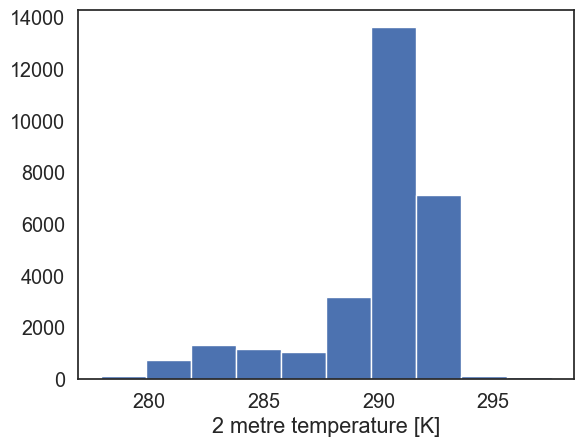

In [7]:

# Plot the sliced data
data_slice.plot()
plt.show()

# Select temperature data for Portugal
porto_ts = data_instance.t2m["t2m"].sel(
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))


In [8]:

# Group by month and calculate daily max temperature
porto_ts_daily_max = porto_ts.groupby('time.month').max(skipna=True)

# Group by month again and calculate the maximum temperature
porto_ts_daily_max_val = porto_ts_daily_max.groupby("month").max(["latitude", "longitude"])


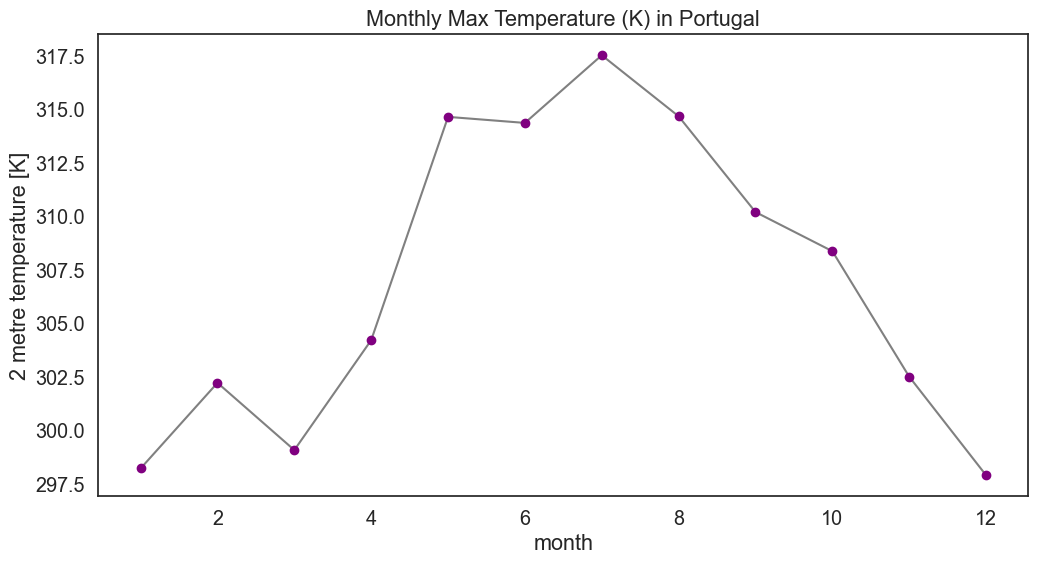

In [9]:

# Plot monthly maximum temperatures in Portugal
f, ax = plt.subplots(figsize=(12, 6))
porto_ts_daily_max_val.plot.line(hue='lat',
                              marker="o",
                              ax=ax,
                              color="grey",
                              markerfacecolor="purple",
                              markeredgecolor="purple")
ax.set(title="Monthly Max Temperature (K) in Portugal")
plt.show()


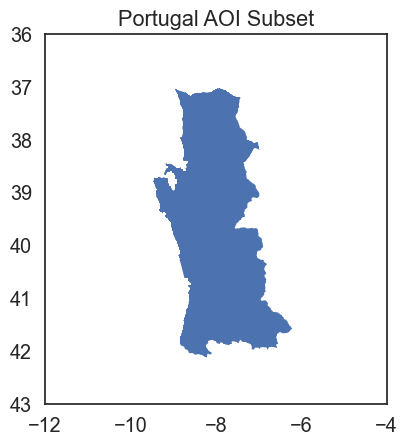

In [10]:

# Set bounding box coordinates
ymin = 43
ymax = 36
xmin = -12
xmax = -4

# Create a subplot and plot the AOI
f, ax = plt.subplots()
data_instance.porto_aoi.plot(ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Portugal AOI Subset")
plt.show()

# Create a region mask
region = regionmask.from_geopandas(data_instance.porto_aoi,
                                    numbers='ID_0',
                                    names='NAME_0',
                                    name='region')

# Define the WGS 84 projection
proj = ccrs.PlateCarree()
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)


c:\Users\kizar\anaconda3\envs\era5\Lib\site-packages\regionmask\core\plot.py:232: FutureWarning: 'proj' has been renamed to 'projection'
  warnings.warn("'proj' has been renamed to 'projection'", FutureWarning)


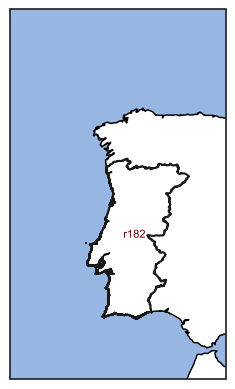

In [11]:

# Plot the region mask
ax = region.plot(
    add_ocean=True,
    resolution="50m",
    proj=proj,
    label="abbrev",
    text_kws=text_kws,
)

# Fine-tune the extent in WGS 84
ax.set_extent([-5, -12, 47, 35], crs=proj)

# Add coastlines
ax.coastlines()

# Show the plot
plt.show()


In [12]:

# Create a 3D mask
porto_mask = regionmask.mask_3D_geopandas(data_instance.porto_aoi,
                                          porto_ts_daily_max.longitude,
                                          porto_ts_daily_max.latitude)

# Select monthly data for Portugal
monthly_porto = porto_ts_daily_max_val.sel(
    month=slice(1, 12))

# Apply the mask to the data
monthly_porto = monthly_porto.where(porto_mask)

# Create a dataset
dataset = monthly_porto.to_dataset(name='t2m')


## Plotting Temperature Data

The code extracts temperature data for a specific date range and spatial extent within Portugal. It then plots this temperature data using matplotlib. The resulting plot shows the variation in temperature over time for the selected area within Portugal.

In [13]:
def plot_temperature_for_month(dataset, month):
    """
    Plot temperature data for a specific month.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing temperature data.
    - month (int): The month to plot (1 to 12).
    """
    if 1 <= month <= 12:
        selected_data = dataset.sel(month=month)
        selected_data['t2m'].plot(figsize=(10, 6))
        plt.title(f'Temperature for Month {month}')
        plt.xlabel('X-axis Label')
        plt.ylabel('Y-axis Label')
        plt.show()
    else:
        print("Invalid month. Please enter a value between 1 and 12.")

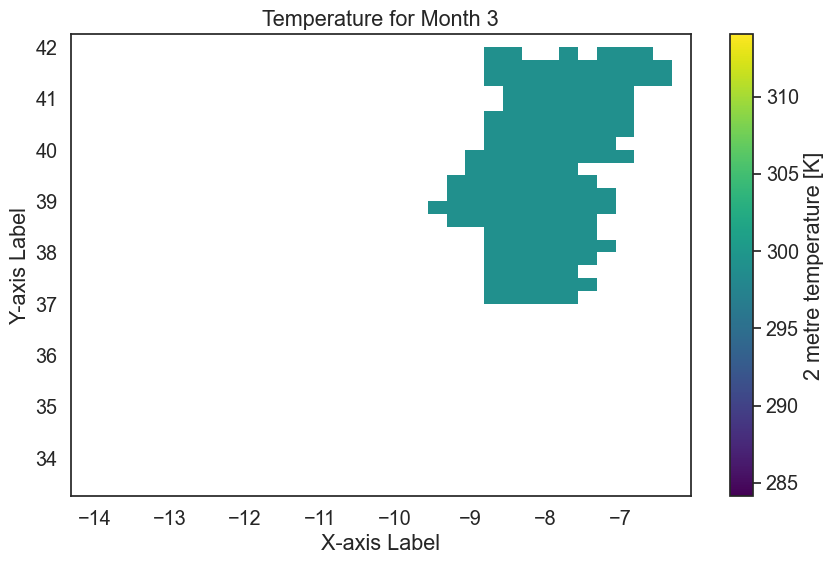

In [14]:
# Get user input for the month (1 to 12)
month = int(input("Enter a month (1 to 12): "))

# Plot temperature data for the specified month
plot_temperature_for_month(dataset, month)